In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import DataLoader, Dataset, random_split, Subset
import matplotlib.pyplot as plt
import os
import random

In [16]:
# 시드 값 고정
seed = 42

# Python 내장 해시 함수의 시드를 고정하여 재현성을 확보 (Python 3.3 이상에서만 적용)
os.environ['PYTHONHASHSEED'] = str(seed)

random.seed(seed) # Python의 random 모듈
np.random.seed(seed )# NumPy의 난수 생성기
torch.manual_seed(seed) # PyTorch의 난수 생성기

torch.cuda.manual_seed(seed) #GPU의 난수 생성기
torch.backends.cudnn.deterministic = True # CuDNN을 사용할 때, 비결정론적 알고리즘을 사용하지 않도록 설정
torch.backends.cudnn.benchmark = False # CuDNN의 벤치마크 기능을 비활성화하여 매번 동일한 연산 경로가 사용되도록 설정

# GPU가 사용 가능하면 CUDA 장치로 설정, 그렇지 않으면 CPU로 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 설정된 장치(device) 출력
device

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/B2E_P.csv')
df.set_index('date', inplace=True)
df.head()

,P
date,
2012-04-01 07:00:00+00:00,58
2012-04-01 07:01:00+00:00,58
2012-04-01 07:02:00+00:00,8
2012-04-01 07:03:00+00:00,7
2012-04-01 07:04:00+00:00,8


                             date    P
2666    2012-04-03 03:26:00+00:00  130
2667    2012-04-03 03:27:00+00:00  133
2668    2012-04-03 03:28:00+00:00  129
2669    2012-04-03 03:29:00+00:00  132
2670    2012-04-03 03:30:00+00:00  127
...                           ...  ...
525513  2013-04-01 05:33:00+00:00  149
525514  2013-04-01 05:34:00+00:00  151
525541  2013-04-01 06:01:00+00:00  152
525542  2013-04-01 06:02:00+00:00  152
525543  2013-04-01 06:03:00+00:00  152

[10831 rows x 2 columns]
이상치 수: 10831
이상치 비율: 2.06%


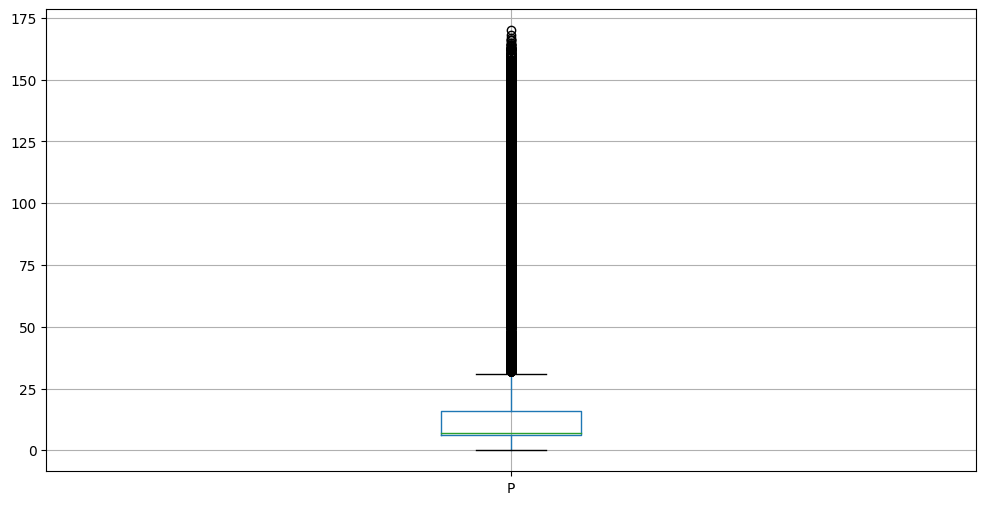

In [31]:
outlier_detected = df[np.abs((df['P'] - df['P'].mean()) / df['P'].std()) > 3]
print(outlier_detected)
outlier_ratio = len(outlier_detected)
print(f"이상치 수: {outlier_ratio}")
print(f"이상치 비율: {round(outlier_ratio/len(df)*100,2)}%")

df.boxplot(figsize=(12, 6))
plt.show()

In [34]:
df = df[df['P'] < 800]

8


In [24]:
# 각 열의 결측치 수
print(df.isnull().sum())

date    0
P       0
dtype: int64


In [37]:
# 데이터 로드 및 전처리 (데이터셋 나누기 전에 수행하는 것이 좋음!)
def load_data_from_csv(df, column_name):
    data = df
    data = data[column_name].values.reshape(-1, 1)

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)

    return scaled_data, scaler

data, scaler = load_data_from_csv(df, 'P')

In [38]:
# 데이터셋 클래스 정의
class B2EDataset(Dataset):
    def __init__(self, data, window_size):
        self.data = data
        self.window_size = window_size

    def __len__(self):
        return len(self.data) - self.window_size

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.window_size]
        y = self.data[idx+self.window_size]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [40]:
# 데이터셋 생성
window_size = 10
dataset = B2EDataset(data, window_size)

# 훈련/검증 데이터 분리 (80% 훈련 데이터, 20% 테스트 데이터)
train_size = int(len(dataset) * 0.80)

# 학습과 테스트 데이터셋을 슬라이싱으로 나누기
train_dataset = Subset(dataset, list(range(train_size)))
test_dataset = Subset(dataset, list(range(train_size, len(dataset))))

# 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [41]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1, dropout=0.2): # LSTM 전체 모델 정의
        super(LSTMModel, self).__init__() # Moudle(부모 클래스의 생성자 호출
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # nn.LSTM을 통해 LSTM 레이어 정의
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)

        # 출력 크기 조정 (FC레이어 = 선형 변환 레이어 정의)
        self.fc = nn.Linear(hidden_size, output_size)

        # 가중치와 편향을 초기화
        self._initialize_weights()

    def _initialize_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'bias' in name:
                nn.init.zeros_(param.data)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)

    def forward(self, x): # x는 입력 데이터 (하나의 batch)
        # 초기 은닉 상태와 셀 상태 정의
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # LSTM 통과
        out, _ = self.lstm(x, (h0, c0))

        # 마지막 시퀀스의 출력만 선택하여 FC 레이어에 통과
        out = self.fc(out[:, -1, :])
        out = torch.sigmoid(out)  # 시그모이드 활성화 함수 추가

        return out

In [44]:
# 모델 학습 함수
def train_model(train_loader, num_epochs=5, learning_rate=0.001, device=device):
    model = LSTMModel().to(device)
    criterion = nn.MSELoss() #손실 함수
    optimizer = optim.Adam(model.parameters(), lr=learning_rate) #최적 가중치를 찾아주는 알고리즘

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for seqs, targets in train_loader:
            seqs, targets = seqs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(seqs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')

    return model

In [45]:
# 모델 학습
model = train_model(train_loader, device=device)

Epoch 1/5, Loss: 0.0005
Epoch 2/5, Loss: 0.0001
Epoch 3/5, Loss: 0.0000
Epoch 4/5, Loss: 0.0000
Epoch 5/5, Loss: 0.0000


In [46]:
# 예측 함수
def predict(model, test_loader, scaler, device=device):
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for seqs, targets in test_loader:
            seqs, targets = seqs.to(device), targets.to(device)
            outputs = model(seqs)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(targets.cpu().numpy())

    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    actuals = scaler.inverse_transform(np.array(actuals).reshape(-1, 1))

    return predictions, actuals

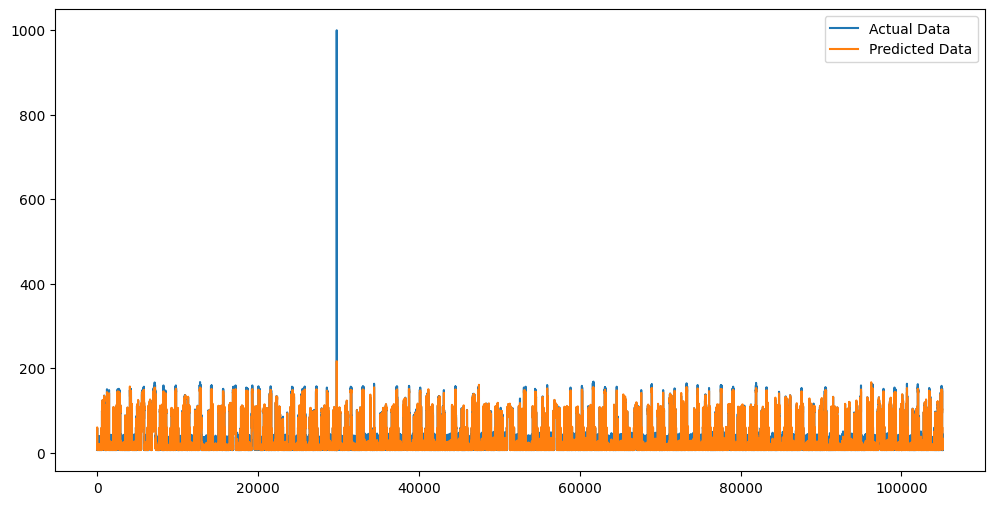

In [54]:
# 테스트 데이터로 예측 수행
predictions, actuals = predict(model, test_loader, scaler, device=device)
model= model.to(device) # device 맞춰주기

# 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(actuals, label='Actual Data')
plt.plot(predictions, label='Predicted Data')
plt.legend()
plt.show()

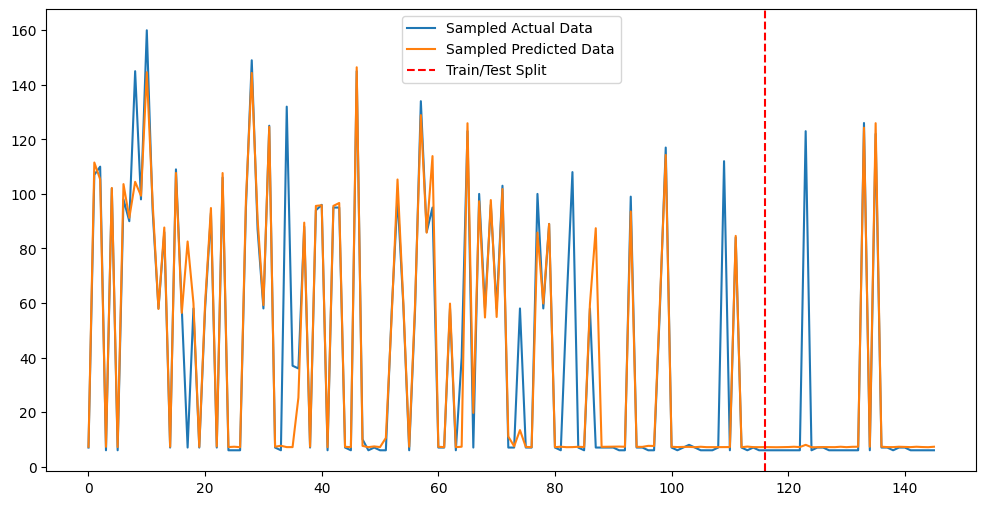

In [55]:
# 샘플링 인덱스 생성 (720개마다 하나씩, 하루에 두 개의 데이터 포인트)
sample_indices = list(range(0, len(actuals), 720))

# 샘플링된 실제 데이터와 예측 데이터
sampled_actuals = np.array(actuals)[sample_indices]
sampled_predictions = np.array(predictions)[sample_indices]

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(sampled_actuals, label='Sampled Actual Data')
plt.plot(sampled_predictions, label='Sampled Predicted Data')

# 데이터셋 분할점을 나타내는 빨간 점선 추가 (80:20 비율로 가정)
split_point = int(0.8 * len(sampled_actuals))  # 샘플링된 데이터에서의 분할점
plt.axvline(x=split_point, color='red', linestyle='--', label='Train/Test Split')

# 범례 추가 및 시각화
plt.legend()
plt.show()


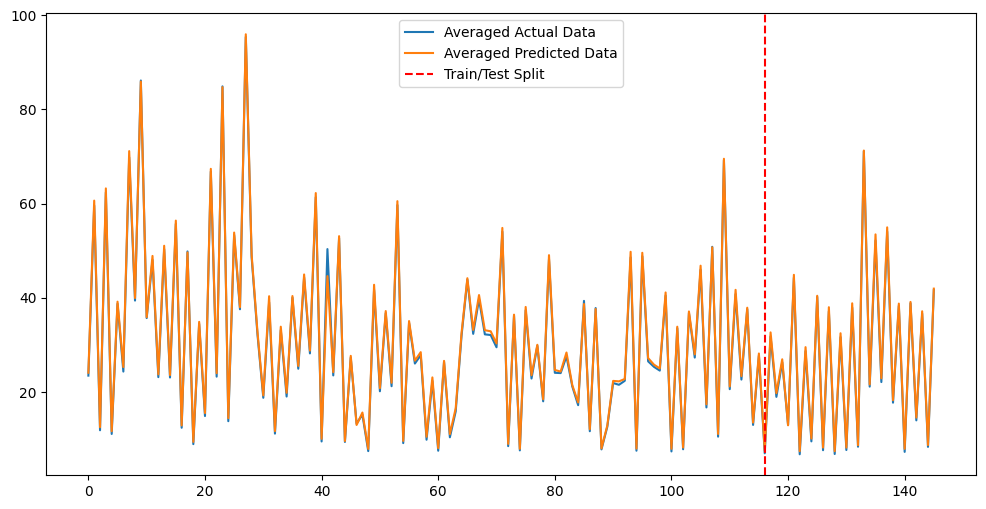

In [56]:
# 데이터를 720개씩 묶어서 평균을 계산하는 함수
def average_data(data, interval):
    # 데이터 길이를 interval로 나누어 묶음의 수를 결정
    data = np.array(data)
    averaged_data = [np.mean(data[i:i+interval]) for i in range(0, len(data), interval)]
    return averaged_data

# 720개마다 평균을 계산
interval = 720
averaged_actuals = average_data(actuals, interval)
averaged_predictions = average_data(predictions, interval)

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(averaged_actuals, label='Averaged Actual Data')
plt.plot(averaged_predictions, label='Averaged Predicted Data')

# 데이터셋 분할점을 나타내는 빨간 점선 추가 (80:20 비율로 가정)
split_point = int(0.8 * len(averaged_actuals))  # 평균을 낸 데이터에서의 분할점
plt.axvline(x=split_point, color='red', linestyle='--', label='Train/Test Split')

# 범례 추가 및 시각화
plt.legend()
plt.show()


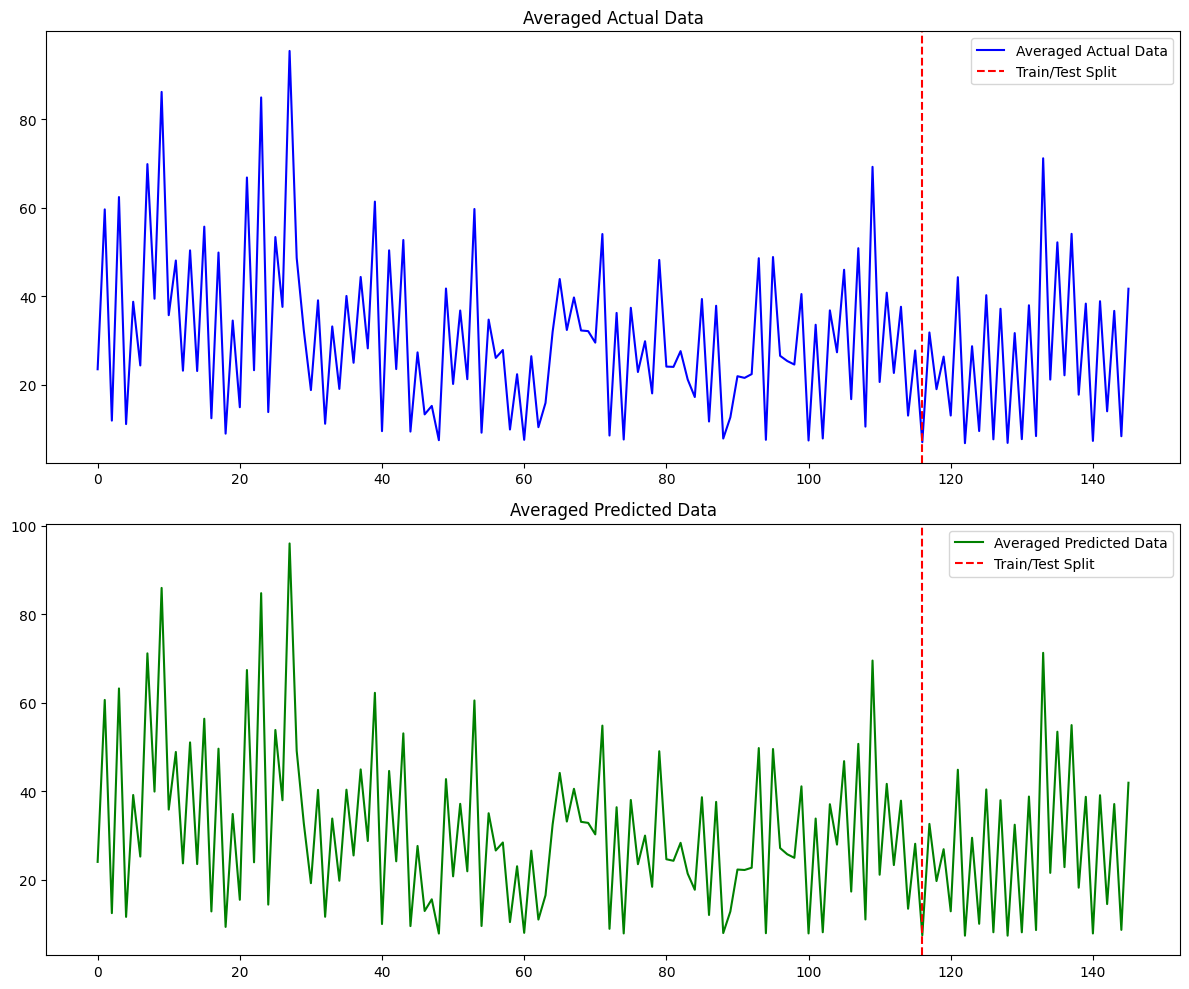

In [60]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))  # 2행 1열의 subplot

# 첫 번째 subplot: Averaged Actual Data
ax1.plot(averaged_actuals, label='Averaged Actual Data', color='blue')
ax1.axvline(x=int(0.8 * len(averaged_actuals)), color='red', linestyle='--', label='Train/Test Split')
ax1.set_title('Averaged Actual Data')
ax1.legend()

# 두 번째 subplot: Averaged Predicted Data
ax2.plot(averaged_predictions, label='Averaged Predicted Data', color='green')
ax2.axvline(x=int(0.8 * len(averaged_predictions)), color='red', linestyle='--', label='Train/Test Split')
ax2.set_title('Averaged Predicted Data')
ax2.legend()

# 그래프 간의 간격 조정
plt.tight_layout()

# 시각화 출력
plt.show()


In [58]:
# 예측 결과와 실제 값 비교
mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)  # RMSE는 MSE의 제곱근
mae = mean_absolute_error(actuals, predictions)

print(f"Mean Squared Error (MSE) on Test Data: {mse:.4f}")
print(f"Root Mean Squared Error (RMSE) on Test Data: {rmse:.4f}")
print(f"Mean Absolute Error (MAE) on Test Data: {mae:.4f}")


Mean Squared Error (MSE) on Test Data: 147.1330
Root Mean Squared Error (RMSE) on Test Data: 12.1298
Mean Absolute Error (MAE) on Test Data: 3.1347
